In [1]:
#| default_exp registration

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interpolation as tcinterp
from importlib import reload

In [3]:
#| export

import numpy as np
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt
import mcubes
import pymeshlab
from copy import deepcopy

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [4]:
from tqdm.notebook import tqdm
np.set_printoptions(suppress=True)

## Consistent cartographic projections across multiple recordings

In notebooks 2 and 3 we saw how to do tissue cartography on a single volumetric image. But often, we have multiple images of very similarly shaped objects - either the successive frames of a movie, or multiple recordings of biological structures with very consistent shape, like the _Drosophila_ egg. We want to use "the same" UV map/cartographic projection for all of the images - both so that we don't need to redo the work of creating the UV map, and so that positions in our cartographic projections always correspond to the same anatomical position on the imaged object (e.g. the anterior side of the _Drosophila_ embryo is always left, and the dorsal midline corresponds to the line $v=1/2$ in UV space).

To do this, we use _mesh registration_. The idea is that we have a _reference mesh_ - for example, from the first frame of a movie - on which a UV map is defined. We then move and deform this mesh so that it fits our _target mesh_ - which describes the surface we want to extract from the volumetric data - as well as possible. The registered reference mesh now fits the volumetric data but still carries the UV map, and can now be used to create a cartographic projection.

If you have a consistently-shaped object that you know you will image many times - in my lab, the early _Drosophila_ embryo, of which we have [hundreds of _in toto_ recordings](https://doi.org/10.25349/D9WW43) - it might make sense to make an idealized "prototypical" mesh with a nice mesh and UV map, that you can use as a reference.

Mesh/point cloud registration and deformation are very well studied problems and we can make use of many robust and already-implemented algorithms. We proceed in two steps:
1. Affine registration: Align reference mesh to target mesh using translations, rotations, and possible rescaling, for instance by by [Iterative Closest Point](https://en.wikipedia.org/wiki/Iterative_closest_point).
2. Wrapping: Move each point on the registered reference mesh to the closest point on the surface defined by the target mesh.

For step 1, we provide some simple python code. We could also use the `pymeshlab` GUI.

For step 2, we can use the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html) in blender, or `pymeshlab`'s `transfer_attributes_per_vertex` filter.

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in notebook 3.

In [5]:
metadata_dict = {'filename': 'registration_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [6]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


In [7]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (1, 95, 254, 94)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

The bright dots outside the embryo are fluorescent beads necessary for sample registration in lightsheet microscopy. You can ignore them.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [8]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [9]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (95, 254, 94)


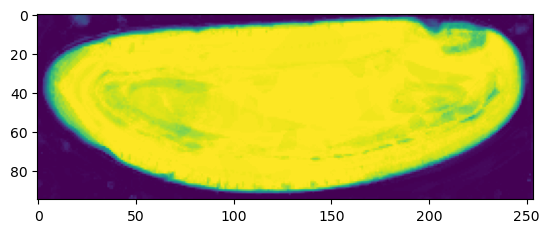

In [10]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [12]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian", sigma=2)
# converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [14]:
mesh = tcio.ObjMesh(vertices_in_microns, faces)
mesh.name = "Drosophila_CAAX-mCherry_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [15]:
# improve mesh quality using meshlab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
ms.meshing_isotropic_explicit_remeshing()
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

## Registration

In the data folder, we have the mesh we just created, `Drosophila_CAAX-mCherry_mesh_remeshed.obj`, as well as out **reference mesh**  `Drosophila_reference.obj` - an idealized _Drosophila_ embryo with a standardized UV mapping, corresponding to a cylindrical projection. You can look at both meshes in the blender file `Drosophila_reference.blend` (where I recentered the mesh from the image data - which you should not do if you want to use it for interpolation!). 

Our goal will now be to register the reference mesh and the deformed mesh using an affine transformation. Affine transformations are generally written as [4d-matrices](https://en.wikipedia.org/wiki/Affine_transformation#Representation), with the extra dimension allowing to save the translation as part of the matrix.

Affine registration proceeds in two parts. First, we get an initial guess by matching centroid and axes of inertia of source and target mesh. Then we refine the registration using the iterative closest point algorithm.
For all calculations, we make use of the KDTree data structure which allows efficient lookup of the closest point from a given point cloud to a query point.

In [18]:
#| export

def package_affine_transformation(matrix, vector):
    """Package matrix transformation & translation into (d+1,d+1) matrix representation of affine transformation."""
    matrix_rep = np.hstack([matrix, vector[:, np.newaxis]])
    matrix_rep = np.pad(matrix_rep, ((0,1),(0,0)), constant_values=0)
    matrix_rep[-1,-1] = 1
    return matrix_rep

def get_inertia(pts, q=0):
    """Get inertia tensor of point cloud. q in [0, 1) removes points with outlier coordinates"""
    pts_nomean = pts - stats.trim_mean(pts,q, axis=0)
    x, y, z = pts_nomean.T
    Ixx = stats.trim_mean(x**2, q)
    Ixy = stats.trim_mean(x*y, q)
    Ixz = stats.trim_mean(x*z, q)
    Iyy = stats.trim_mean(y**2, q)
    Iyz = stats.trim_mean(y*z, q)
    Izz = stats.trim_mean(z*z, q)
    return np.array([[Ixx, Ixy, Ixz], [Ixy,Iyy, Iyz], [Ixz, Iyz, Izz]])

def align_by_centroid_and_intertia(source, target, q=0, scale=True, shear=False, n_samples=10000):
    """
    Align source point cloud to target point cloud using affine transformation.
    
    Align by matching centroids and axes of intertia tensor. Since the inertia tensor is invariant
    under reflections along its principal axes, all 2^3 reflections are tried and the one leading
    to best agreement with the target is chosen.
    
    Parameters
    ----------
    source : np.array of shape (n_source, 3)
        Point cloud to be aligned.
    target : np.array of shape (n_target, 3)
        Point cloud to align to.
    q : float, optional, default 0
        Quantile for outlier removal. Removes points with coordinates outside (qth, (1-1)qth) quantile from
        calculation of intertia tensor and centroid
    scale : bool, default True
        Whether to allow scale transformation (True) or rotations only (False)
    shear : bool, default False
        Whether to allow shear transformation (True) or rotations/scale only (False)
    n_samples : int, optional
        Number of samples of source to use when estimating distances.

    Returns
    -------
    affine_matrix_rep : np.array of shape (4, 4)
        Affine transformation source -> target
    aligned : np.array of shape (n_source, 3)
        Aligned coordinates
    """
    target_centroid = stats.trim_mean(target, q, axis=0)
    target_inertia = get_inertia(target, q=q)
    target_eig = np.linalg.eigh(target_inertia)

    source_centroid = stats.trim_mean(source, q, axis=0)
    source_inertia = get_inertia(source, q=q)
    source_eig = np.linalg.eigh(source_inertia)

    flips = list(tcio.flatten([[[np.diag([i,j,k]) for i in [-1,1]] for j in [-1,1]] for k in [-1,1]], max_depth=2))
    trafo_matrix_candidates = []
    for flip in flips:
        if shear:
            trafo_matrix = (source_eig.eigenvectors
                            @ np.diag(np.sqrt(target_eig.eigenvalues/source_eig.eigenvalues))
                            @ flip @ target_eig.eigenvectors.T)
        elif scale and not shear:
            scale_fact = np.sqrt(stats.gmean(target_eig.eigenvalues)/stats.gmean(source_eig.eigenvalues))
            trafo_matrix = scale_fact*source_eig.eigenvectors@flip@target_eig.eigenvectors.T
        elif not scale and not shear:
            trafo_matrix = source_eig.eigenvectors@flip@target_eig.eigenvectors.T
        trafo_matrix = trafo_matrix.T
        trafo_matrix_candidates.append(trafo_matrix)
    tree = spatial.cKDTree(target)
    samples = source[np.random.randint(low=0, high=source.shape[0], size=min([n_samples, source.shape[0]])),:]
    distances = []
    for trafo_matrix in trafo_matrix_candidates:
        trafo_translate = target_centroid - trafo_matrix@source_centroid
        aligned = samples@trafo_matrix.T + trafo_translate
        distances.append(stats.trim_mean(tree.query(aligned)[0], q))
    trafo_matrix = trafo_matrix_candidates[np.argmin(distances)]
    trafo_translate = target_centroid - trafo_matrix@source_centroid
    aligned = source@trafo_matrix.T + trafo_translate
    affine_matrix_rep = np.round(package_affine_transformation(trafo_matrix, trafo_translate),decimals=2)
    return affine_matrix_rep, aligned

In [19]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"registration_example/Drosophila_reference.obj")

# for illustration purposes, let's rotate and scale the reference mesh so it's off
mesh_ref.vertices = 1.1 * mesh_ref.vertices @ stats.special_ortho_group.rvs(3)

In [21]:
# let's test this function

q = 0.0

trafo_centroid_intertia, vs_prealigned = align_by_centroid_and_intertia(mesh_ref.vertices,
                                                                        mesh_data.vertices,
                                                                        q=q, scale=True, shear=True)
data_centroid = stats.trim_mean(mesh_data.vertices, q, axis=0)
data_inertia = get_inertia(mesh_data.vertices, q=q)
data_eig = np.linalg.eigh(data_inertia)

ref_centroid = stats.trim_mean(mesh_ref.vertices, q, axis=0)
ref_inertia = get_inertia(mesh_ref.vertices, q=q)
ref_eig = np.linalg.eigh(ref_inertia)

prealigned_centroid = stats.trim_mean(vs_prealigned, q, axis=0)
prealigned_inertia = get_inertia(vs_prealigned, q=q)
prealigned_eig = np.linalg.eigh(prealigned_inertia)

In [22]:
prealigned_eig.eigenvalues, data_eig.eigenvalues

(array([ 3101.87601279,  3205.66161646, 19216.42268169]),
 array([ 3101.87601279,  3205.66161646, 19216.42268169]))

In [23]:
# we correctly matched the axes of intertia and the centroids

prealigned_eig.eigenvalues / data_eig.eigenvalues, np.linalg.norm(data_centroid - prealigned_centroid)

(array([1., 1., 1.]), 1.658839590136016e-12)

In [24]:
prealigned_eig.eigenvectors, data_eig.eigenvectors

(array([[ 0.45991541,  0.88736717, -0.03251643],
        [ 0.03891714,  0.01644055,  0.99910718],
        [-0.8871095 ,  0.46077024,  0.02697253]]),
 array([[ 0.45991541,  0.88736717, -0.03251643],
        [ 0.03891714,  0.01644055,  0.99910718],
        [-0.8871095 ,  0.46077024,  0.02697253]]))

In [25]:
# mean distance to closest target

tree = spatial.cKDTree(mesh_data.vertices)
np.mean(tree.query(mesh_ref.vertices)[0]), np.mean(tree.query(vs_prealigned)[0])

(136.61782173289183, 6.159657409292091)

In [26]:
%%timeit

_ = align_by_centroid_and_intertia(mesh_ref.vertices, mesh_data.vertices, q=q, scale=False)

59.1 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
# we now save the pre-registered mesh. Note that we want to transform both our
# mesh coordinates and the corresponding normals, as well as potentially flip face orientation

mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_centroid_intertia)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"registration_example/Drosophila_reference_preregistered.obj")

### Iterative closest point algorithm

We can refine the initial registration with the ICP algorithm. This code is based on `scipy.spatial.procrustes` and `trimesh.registration`. I am including a new implementation for optimization and dependecy minimization.

In [54]:
#| export

def procrustes(source, target, scale=True):
    """
    Procrustes analysis, a similarity test for two data sets.

    Copied from scipy.spatial.procrustes, modified to return the transform
    as a affine matrix, and return the transformed source data in the original,
    non-normalized coordinates.

    Each input matrix is a set of points or vectors (the rows of the matrix).
    The dimension of the space is the number of columns of each matrix. Given
    two identically sized matrices, procrustes standardizes both such that:

    - tr(AA^T) = 1.
    - Both sets of points are centered around the origin.

    Procrustes then applies the optimal transform to the source matrix
    (including scaling/dilation, rotations, and reflections) to minimize the
    sum of the squares of the pointwise differences between the two input datasets.

    This function is not designed to handle datasets with different numbers of
    datapoints (rows).  If two data sets have different dimensionality
    (different number of columns), simply add columns of zeros to the smaller
    of the two.
    

    Parameters
    ----------
    source : array_like
        Matrix, n rows represent points in k (columns) space. The data from
        source will be transformed to fit the pattern in target.
    target : array_like
        Maxtrix, n rows represent points in k (columns) space. 
        target is the reference data. 
    scale : bool, default True
        Whether to allow scaling transformations

    Returns
    -------
    trafo_affine : array_like
        (4,4) array representing the affine transformation from source to target.
    aligned : array_like
        The orientation of source that best fits target.
    disparity : float
        np.linalg.norm(aligned-target, axis=1).mean()
    """
    mtx1 = np.array(target, dtype=np.float64, copy=True)
    mtx2 = np.array(source, dtype=np.float64, copy=True)

    if mtx1.ndim != 2 or mtx2.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.shape != mtx2.shape:
        raise ValueError("Input matrices must be of same shape")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")

    # translate all the data to the origin
    centroid1, centroid2 = (np.mean(mtx1, 0), np.mean(mtx2, 0))
    mtx1 -= centroid1
    mtx2 -= centroid2

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)
    if norm1 == 0 or norm2 == 0:
        raise ValueError("Input matrices must contain >1 unique points")
    mtx1 /= norm1
    mtx2 /= norm2
    # transform mtx2 to minimize disparity
    R, s = linalg.orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s

    # retranslate and scale
    aligned = norm1 * mtx2 + centroid1

    # measure the dissimilarity between the two datasets
    disparity = np.mean(np.linalg.norm(aligned-target, axis=1))

    # assemble the linear transformation
    if scale:
        trafo_matrix = (norm1/norm2)*s*R
    else:
        trafo_matrix = (norm1/norm2)*R
    trafo_translate = centroid1 - trafo_matrix@centroid2
    trafo_affine = package_affine_transformation(trafo_matrix, trafo_translate)
    
    return trafo_affine, aligned, disparity

In [71]:
mesh_ref = tcio.ObjMesh.read_obj(f"registration_example/Drosophila_reference.obj")

In [79]:
source = np.copy(mesh_ref.vertices)
target = 1.3*mesh_ref.vertices@ stats.special_ortho_group.rvs(3) + np.array([12,12,1000])

In [80]:
trafo_affine, transformed, cost = procrustes(source, target)
affine_transformed = source@trafo_affine[:3,:3].T + trafo_affine[:3,-1]

In [81]:
cost

5.0078697136620175e-12

In [82]:
transformed

array([[  43.03609993,  111.6022002 , 1315.45616852],
       [  30.78447168,  102.59408821, 1316.20651946],
       [  23.94867885,   97.34929133, 1315.26618913],
       ...,
       [ -24.86991084,  -92.3371241 ,  691.72289768],
       [ -21.12049991,  -90.58295504,  687.59164736],
       [ -14.54567257,  -86.89947611,  682.58915989]])

In [83]:
affine_transformed

array([[  43.03609993,  111.6022002 , 1315.45616852],
       [  30.78447168,  102.59408821, 1316.20651946],
       [  23.94867885,   97.34929133, 1315.26618913],
       ...,
       [ -24.86991084,  -92.3371241 ,  691.72289768],
       [ -21.12049991,  -90.58295504,  687.59164736],
       [ -14.54567257,  -86.89947611,  682.58915989]])

In [84]:
target

array([[  43.03609993,  111.6022002 , 1315.45616852],
       [  30.78447168,  102.59408821, 1316.20651946],
       [  23.94867885,   97.34929133, 1315.26618913],
       ...,
       [ -24.86991084,  -92.3371241 ,  691.72289768],
       [ -21.12049991,  -90.58295504,  687.59164736],
       [ -14.54567257,  -86.89947611,  682.58915989]])

In [365]:
#| export

def icp(source, target, initial=None, threshold=1e-4, max_iterations=20, scale=True, n_samples=1000):
    """
    Apply the iterative closest point algorithm to align point cloud a with
    point cloud b. Will only produce reasonable results if the
    initial transformation is roughly correct. Initial transformation can be
    found by applying Procrustes' analysis to a suitable set of landmark
    points (often picked manually), or by inertia+centroid based alignment,
    implemented in align_by_centroid_and_intertia.

    Parameters
    ----------
    source : (n,3) float
      Source points in space.
    target : (m,3) float or Trimesh
      Target points in space or mesh.
    initial : (4,4) float
      Initial transformation.
    threshold : float
      Stop when change in cost is less than threshold
    max_iterations : int
      Maximum number of iterations
    scale : bool, optional
      Whether to allow dilations. If False, orthogonal procrustes is used
    n_samples : int or None
        If not None, n_samples sample points are randomly chosen from source array for distance computation
    
    Returns
    ----------
    matrix : (4,4) float
      The transformation matrix sending a to b
    transformed : (n,3) float
      The image of a under the transformation
    cost : float
      The cost of the transformation
    """
    # initialize transform matrix
    total_matrix = np.eye(4) if initial is None else initial
    tree = spatial.cKDTree(target)
    # subsample and apply initial transformation
    samples = (source[np.random.randint(low=0, high=source.shape[0], size=min([n_samples, source.shape[0]])),:]
               if n_samples is not None else source[:])
    samples = samples@total_matrix[:3,:3].T + total_matrix[:3,-1]
    # start with infinite cost
    old_cost = np.inf
    # avoid looping forever by capping iterations
    for _ in range(max_iterations):
        # Find closest point in target to each point in sample and align
        closest = target[tree.query(samples, 1)[1]]
        matrix, samples, cost = procrustes(samples, closest, scale=scale)
        # update a with our new transformed points
        total_matrix = np.dot(matrix, total_matrix)
        if old_cost - cost < threshold:
            break
        else:
            old_cost = cost
    aligned = source@total_matrix[:3,:3].T + total_matrix[:3,-1]
    return total_matrix, aligned, cost

In [88]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"registration_example/Drosophila_reference.obj")

# for illustration purposes, let's rotate and scale the reference mesh so it's off
mesh_ref = mesh_ref.apply_affine_to_mesh(1.1 * stats.special_ortho_group.rvs(3))

In [89]:
source = np.copy(mesh_ref.vertices)
target = np.copy(mesh_data.vertices)
tree = spatial.cKDTree(target)

In [90]:
np.mean(tree.query(source)[0]) 

138.30546814863402

In [91]:
trafo_initial, prealigned = align_by_centroid_and_intertia(source, target, q=0, scale=True, shear=True)

In [92]:
np.mean(tree.query(prealigned)[0]) 

6.159657409292103

In [93]:
trafo_icp, icp_aligned, cost = icp(source, target, initial=trafo_initial, threshold=1e-4, max_iterations=100,
                                   scale=True, n_samples=5000)

In [94]:
np.mean(tree.query(icp_aligned)[0]) 

5.6256151528303695

### Registration in MeshLab

You can also perform registration graphically in MeshLab - see this tutorial: https://www.youtube.com/watch?v=30bJcj6yA4c. Use this if you have problems with the automated method above.

## Wrapping

Now that we have registered the mesh, we can wrap it! Let's first do it using blender with the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html). Go to the "layout" tab and click the "blue wrench" on the right to add a modifier. Search for shrinkwrap, select the target, and use "Tangent Normal Project" for best results:

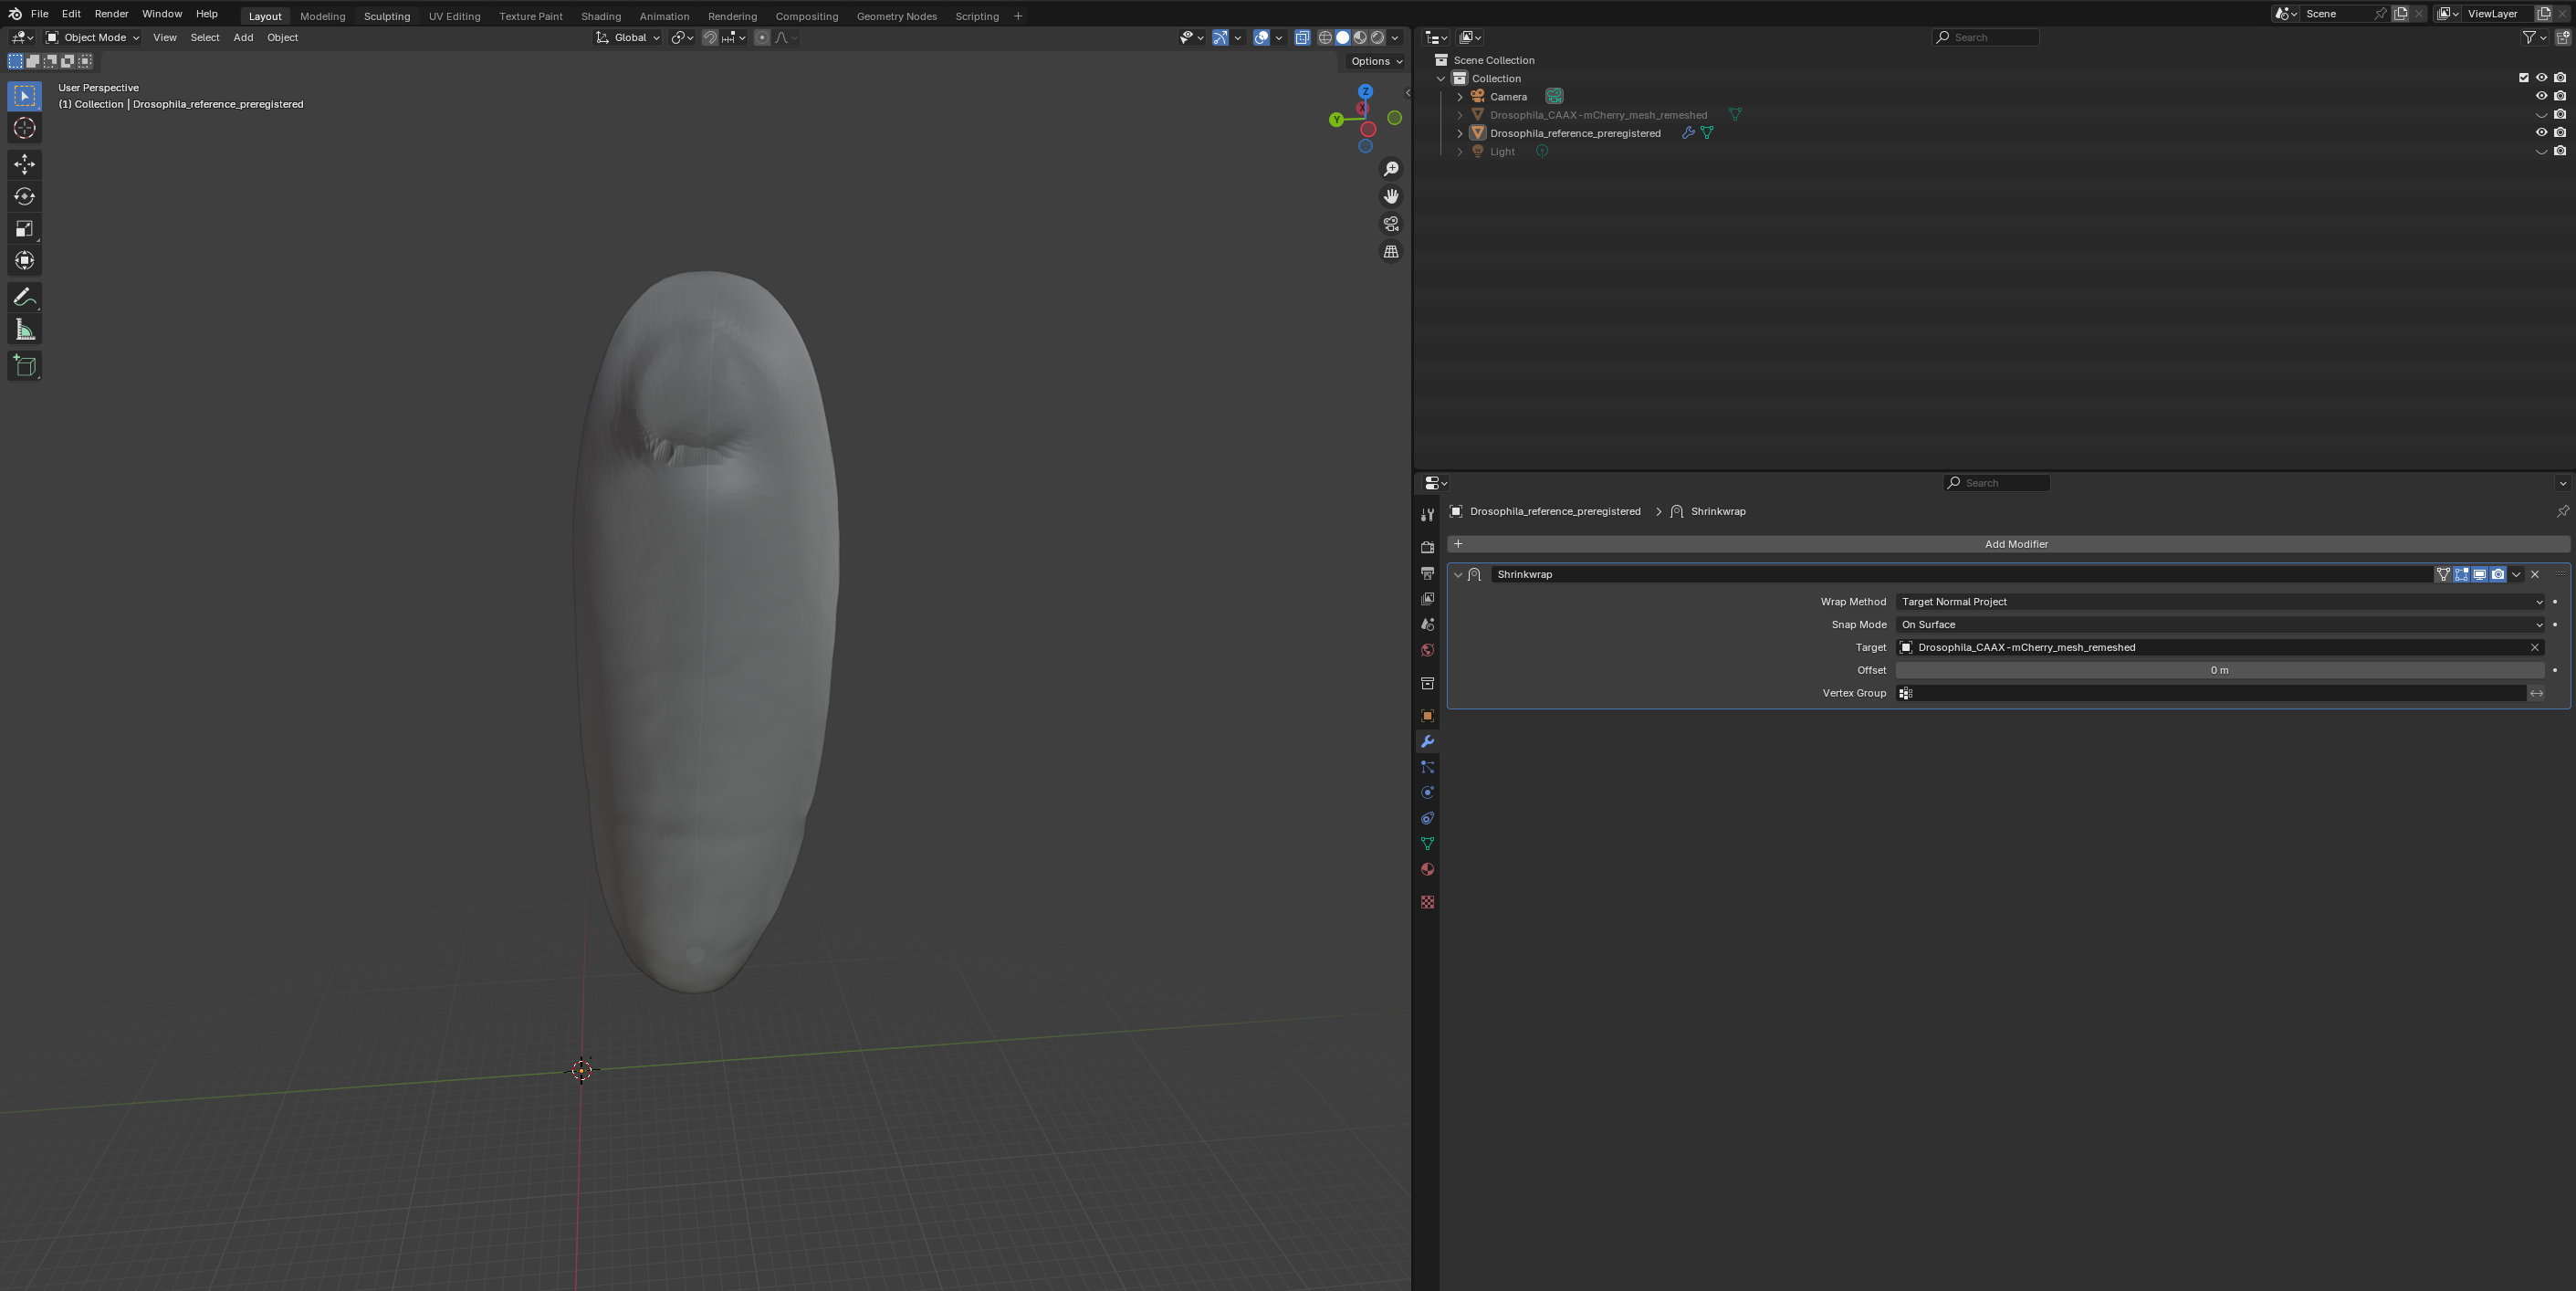

If things look good, click "Apply" to make the modifier permanent and export the mesh as `Drosophila_reference_wrapped.obj`.

### Normals and normal-related problems

This may be a good point to note that if you have any problems with multilayer projections, your normals may be messed up. [Some advice](https://all3dp.com/2/blender-recalculate-normals-simply-explained/) on how to visualize and if necessary, recalculate mesh normals.

**Useful tools**: "Recalculate normals" (under "Mesh" in "Edit Mode"), and the modifier "Normals -> Weighted Normal" (smoothes normals) and "Deform -> Smooth".

In [204]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
mesh = tcio.ObjMesh.read_obj(f"registration_example/Drosophila_reference_wrapped.obj")
resolution = metadata_dict["resolution_in_microns"]

In [209]:
slice_image, slice_vertices, slice_normals = tcio.get_cross_section_vertices_normals(1, 100,
                                image, mesh, metadata_dict["resolution_in_microns"], width=1.5)

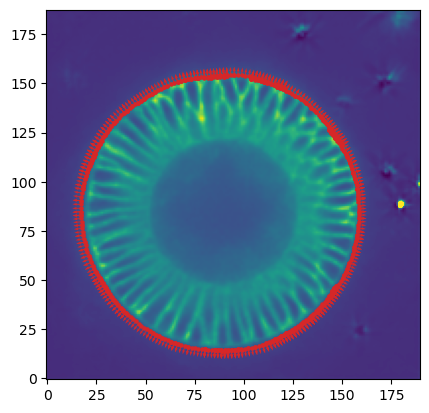

In [210]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")
plt.quiver(*slice_vertices.T, *slice_normals.T, color="tab:red")

plt.imshow(slice_image[0], vmax=10000, origin="lower")

## Procedural wrapping

Of course, we do not want to have to do this by hand for a movie with $\sim100$ frames! In notebook 4b, we will introduce tools to automate the wrapping process.

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections. We will compare it with the automatic sphere unwrap on the original data mesh.

In [95]:
normal_offsets = np.array([-4, -2, 0, 2]) ##np.linspace(-5, 2, 8) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [211]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [96]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"registration_example/Drosophila_reference_wrapped.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

In [97]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh="registration_example/Drosophila_CAAX-mCherry_mesh_remeshed_sphere_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

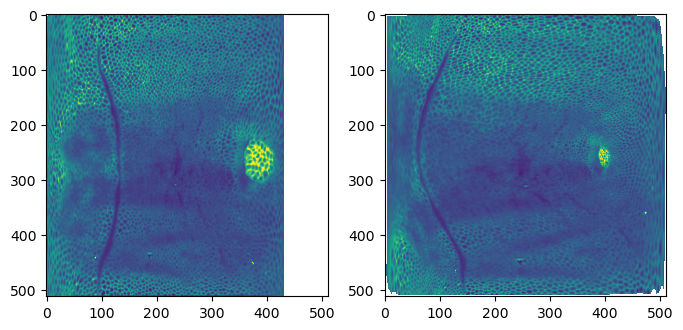

In [98]:
# show the projected data - why is there a systematic error when using the wrapped mesh??

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 1], vmax=10000)
ax2.imshow(projected_data[0, 1][::-1,::-1].T, vmax=10000)

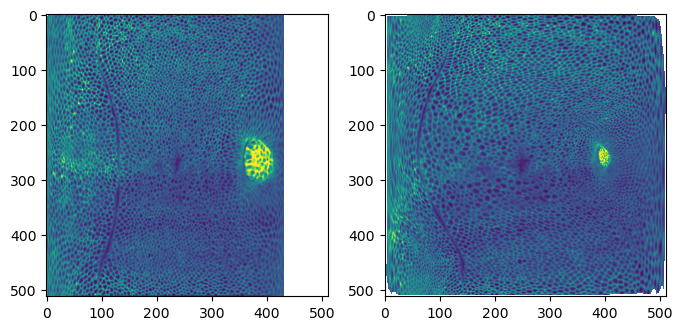

In [99]:
fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data[0, 0][::-1,::-1].T, vmax=10000)

In [56]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data_wrapped, texture_path, normalization=(0.01, 0.99))

In [50]:
# save images as .tif stack for analysis
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data_wrapped, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates_wrapped)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals_wrapped)

Let's add a shader to check the texture looks good:

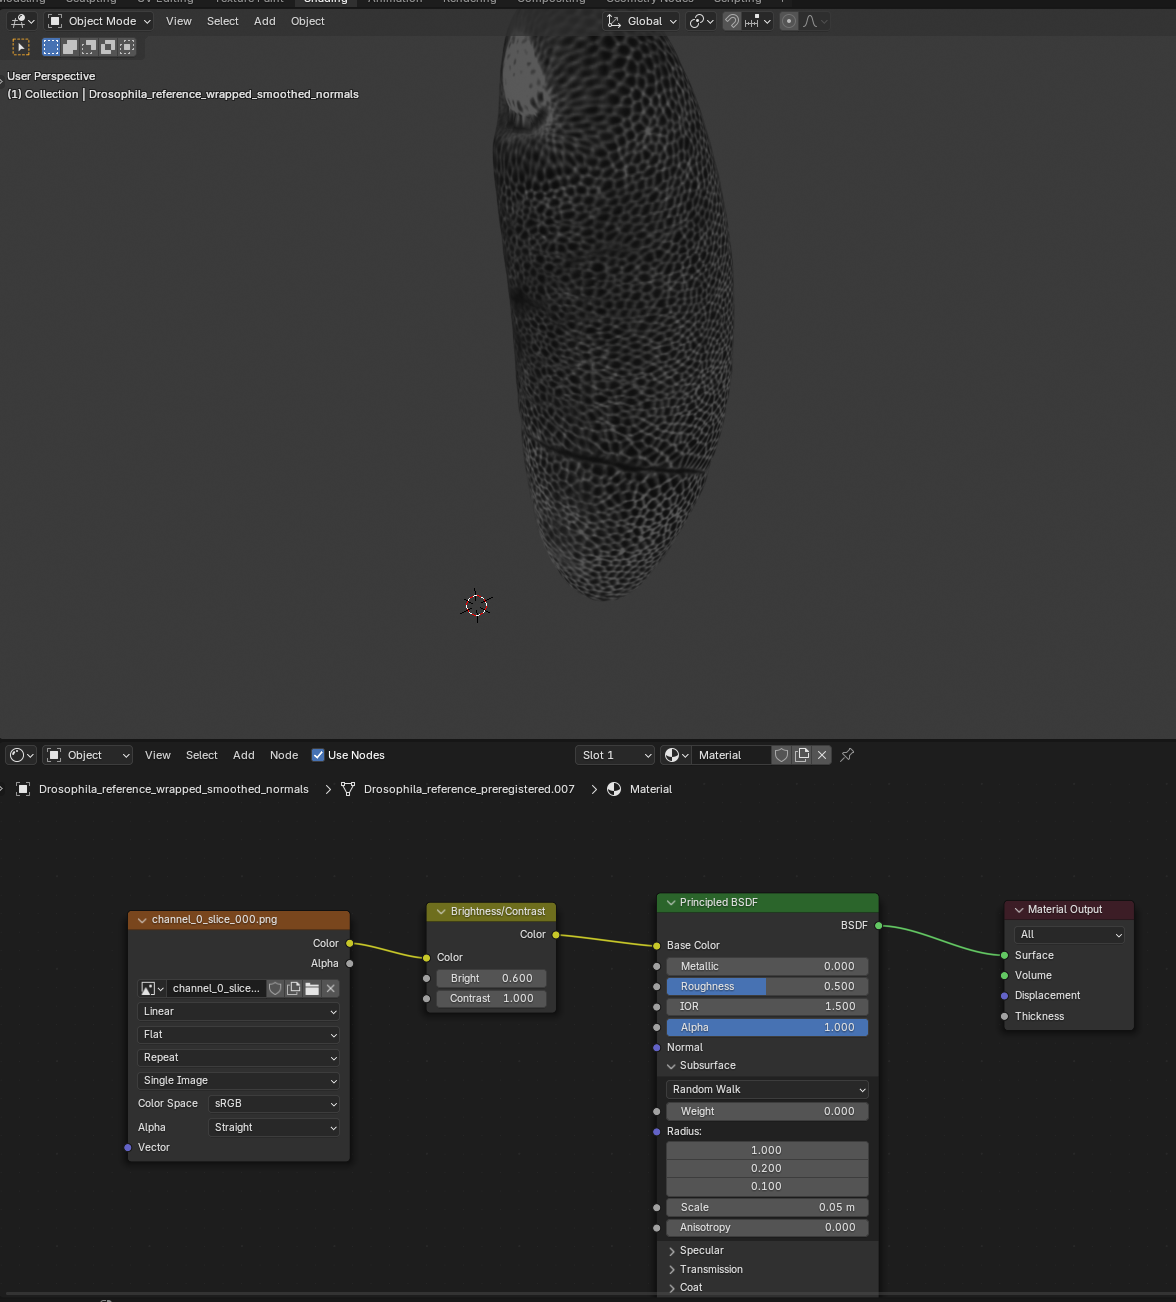
